# Test Models

This notebook tests deep learning models for enhanced JPEG reconstruction.

In [1]:
%matplotlib inline
from __future__ import print_function, division
import matplotlib.pylab as plt
import numpy as np
from keras.optimizers import Adam
import os
import glob
import io
from PIL import Image
import sys

from tensorflow.spectral import dct, idct
from scipy.fftpack import dct as DCT, idct as IDCT
from tensorflow.keras.backend import eval
import skimage.measure as metrics

# Importing our U-Net model
MY_UTILS_PATH = "../Modules/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
from models import unet_old, unet, my_unet
from cs_models import deep_cascade_unet_no_dc
from metrics import calculate_metrics

Using TensorFlow backend.


In [2]:
def dct2d(im):
    return DCT(DCT(im,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')
def idct2d(mat):
    return IDCT(IDCT(mat,type=2,axis=0,norm='ortho'),type=2,axis=1,norm='ortho')

def dct_in_blocks(im, block_size = 8):

    rows, cols = im.shape[0], im.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    dct_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = im[i:i+block_size, j:j+block_size]
            dct_matrix[i:i+block_size,j:j+block_size] = dct2d(block)

    return dct_matrix

def idct_in_blocks(dct_mat, block_size = 8):

    rows, cols = dct_mat.shape[0], dct_mat.shape[1]

    # block size: 8x8
    if rows % block_size == cols % block_size == 0:
        blocks_count = rows // block_size * cols // block_size
    else:
        raise ValueError(("the width and height of the image "
                          "should both be mutiples of %block_size"))

    im_matrix = np.zeros((rows, cols))

    for i in range(0, rows, block_size):
        for j in range(0, cols, block_size):

            block = dct_mat[i:i+block_size, j:j+block_size]
            im_matrix[i:i+block_size,j:j+block_size] = idct2d(block)

    return im_matrix


In [3]:
# Train and validation data paths
test_path = "/home/ubuntu/volume1/TIFF/Testing/*.tif"

# Listing train and validation images
test_images = sorted(glob.glob(test_path))

# Summary of images
print("Test set size:", len(test_images))

Test set size: 16110


In [4]:
H,W = 256, 256
norm = 255.0
compr_range = (10,20)

test_unc = np.zeros((len(test_images),H,W,1), dtype=np.float32)
test_compr = test_unc.copy()

dct_test_unc = test_unc.copy()
dct_test_compr = test_unc.copy()

compr_test = np.random.choice(np.arange(compr_range[0],compr_range[1], dtype=int), \
                               len(test_images),replace = True)

# Test set
for ii in range(len(test_images)):
    # Load uncompressed image
    im1 = Image.open(test_images[ii])
    test_unc[ii,:,:,0] = np.array(im1, dtype=np.float32)

    # JPEG compress the image    
    buf = io.BytesIO()
    im1.save(buf, "JPEG", quality=int(compr_test[ii]))
    im2 = Image.open(buf)
    test_compr[ii,:,:,0] = np.array(im2, dtype=np.float32)

test_unc -= 128.0
test_compr -= 128.0

test_unc /= 128.0
test_compr /= 128.0

In [5]:
useBlocks = True

if useBlocks:
    for ii in range(len(test_images)):
        dct_test_compr[ii,:,:,0] = dct_in_blocks(test_compr[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        dct_test_compr[ii,:,:,0] = dct2d(test_compr[ii,:,:,0])
    
# # keep min/max values to de-normalize later
# dct_test_compr_min = np.zeros(len(test_images))
# dct_test_compr_max = np.zeros(len(test_images))

# for ii in range(len(test_images)):
#     dct_test_compr_min[ii] = np.min(dct_test_compr[ii,:,:,0])
#     dct_test_compr_max[ii] = np.max(dct_test_compr[ii,:,:,0])

# print(dct_test_compr_min.shape)
# print(dct_test_compr_max.shape)

In [6]:
opt=Adam(lr=0.0001)
model_name = "../Models/residual_wnet_pydct_data_augmentation_compress_10_20_2019-03-27-pretrained.hdf5"
#model = unet_old(input_size = (256 ,256 ,1),drop = 0.0,residual = True)
#model=my_unet()
model = deep_cascade_unet_no_dc(depth_str='ii')
model.compile(loss = "mse",optimizer=opt)

model.load_weights(model_name)

Instructions for updating:
Colocations handled automatically by placer.
0 i
Append U-net block
1 i
Append U-net block


In [7]:
pred = model.predict(dct_test_compr)

In [8]:
img_pred = test_unc.copy()

test_unc *= 128.0
test_unc += 128.0

test_compr *= 128.0
test_compr += 128.0

In [9]:
if useBlocks:
    for ii in range(len(test_images)):
        img_pred[ii,:,:,0] = idct_in_blocks(pred[ii,:,:,0])
else:
    for ii in range(len(test_images)):
        img_pred[ii,:,:,0] = idct2d(pred[ii,:,:,0])
        
img_pred *= 128.0
img_pred += 128.0

0.0 169.0
-3.2130585 172.30624


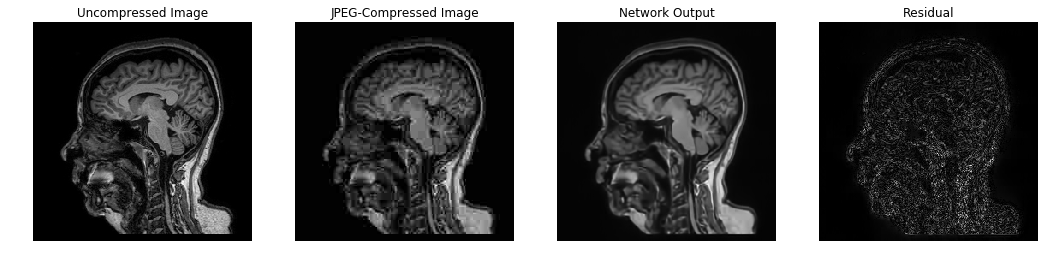

In [10]:
#print(pred)

slc = 65

print(np.min(test_unc[slc,:,:,0]), np.max(test_unc[slc,:,:,0]))
print(np.min(img_pred[slc,:,:,0]),np.max(img_pred[slc,:,:,0]))

# plt.figure(figsize = (9,18))
# plt.subplot(3,1,1)
# plt.axis("off")
# plt.title("Uncompressed Image", fontsize=24)
# plt.imshow(dct_test_unc[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,2)
# plt.axis("off")
# plt.title("Network Output", fontsize=24)
# plt.imshow(pred[slc,:,:,0],cmap = "gray")
# plt.subplot(3,1,3)
# plt.axis("off")
# plt.title("Residual", fontsize=24)
# plt.imshow((dct_test_unc[slc,:,:,0] - img_pred[slc,:,:,0]),cmap = "gray")
# plt.show()

plt.figure(figsize = (18,12))
plt.subplot(1,4,1)
plt.axis("off")
plt.title("Uncompressed Image")
plt.imshow(test_unc[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,2)
plt.axis("off")
plt.title("JPEG-Compressed Image")
plt.imshow(test_compr[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,3)
plt.axis("off")
plt.title("Network Output")
plt.imshow(img_pred[slc,:,:,0],cmap = "gray")
plt.subplot(1,4,4)
plt.axis("off")
plt.title("Residual")
plt.imshow(abs(test_unc[slc,:,:,0] - img_pred[slc,:,:,0]),cmap = "gray")
plt.show()

Test set results


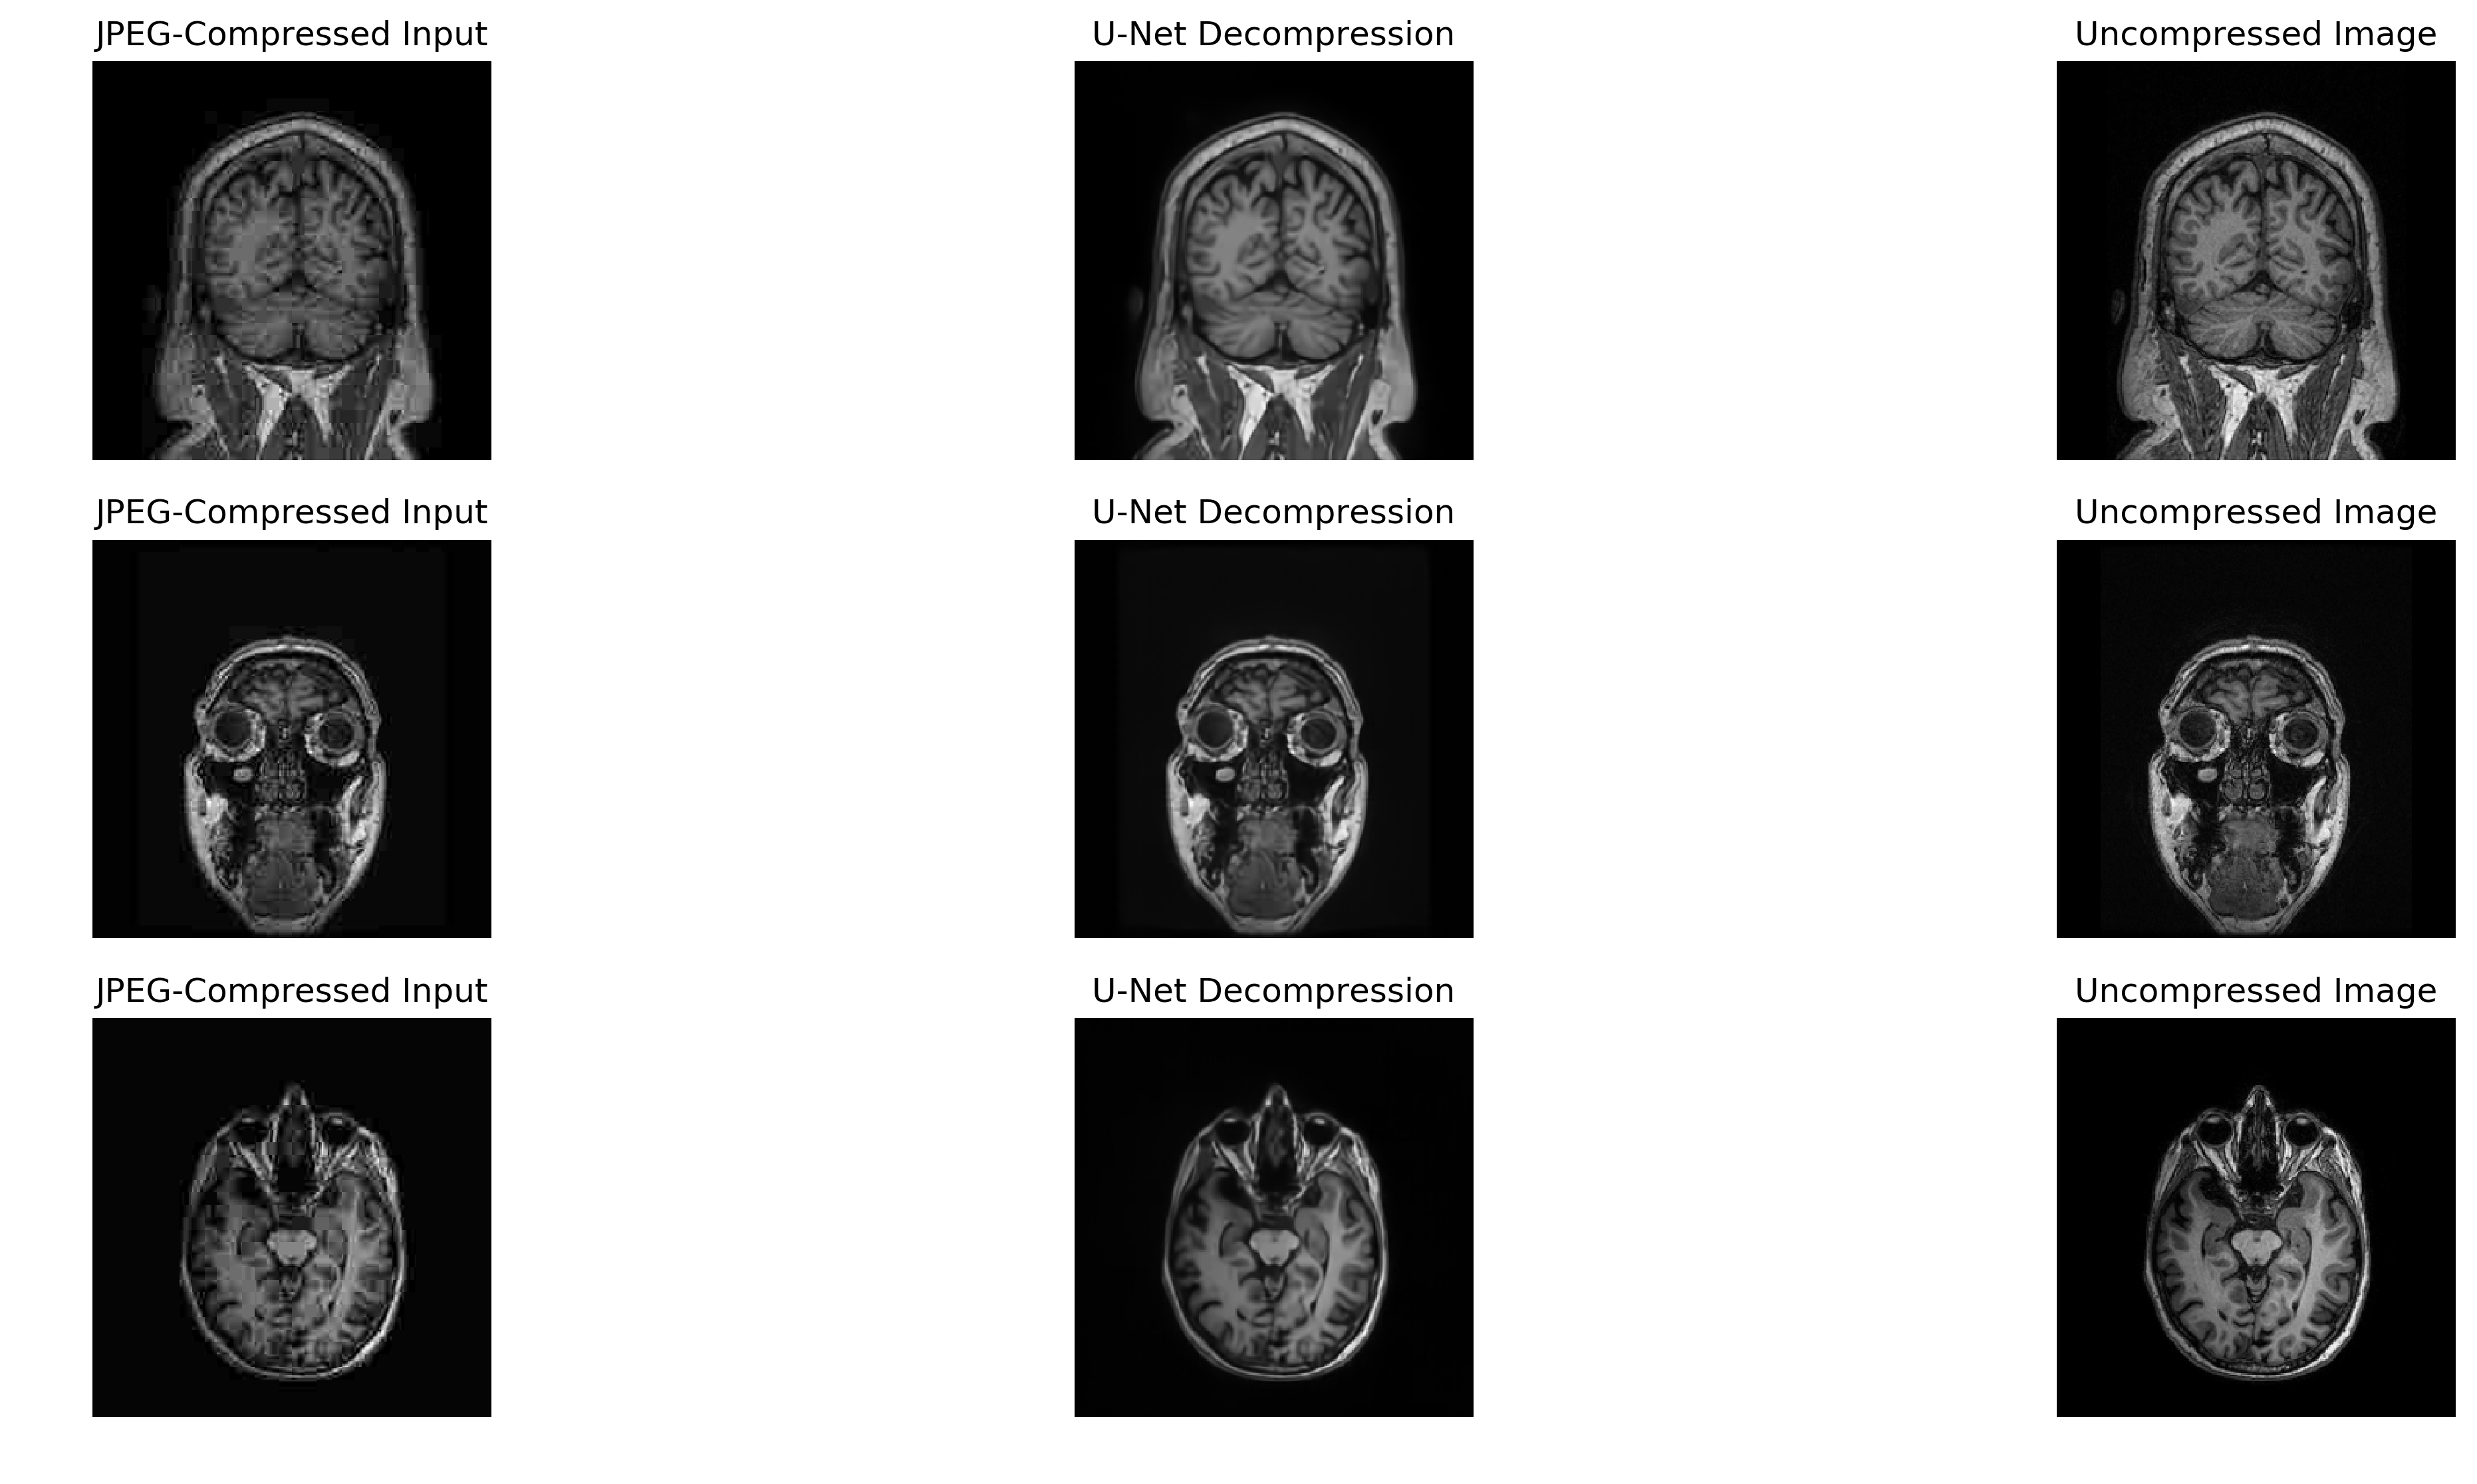

In [20]:
indexes_test = np.arange(len(test_images),dtype = int)
np.random.shuffle(indexes_test)
indexes_test = indexes_test[:3]

print("Test set results")
plt.figure(figsize = (18,9),dpi = 300)
for ii in range(3):
    plt.subplot(3,3,3*ii+1)
    plt.imshow(test_compr[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("JPEG-Compressed Input")
    plt.subplot(3,3,3*ii+2)
    plt.imshow(img_pred[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("U-Net Decompression")
    plt.subplot(3,3,3*ii+3)
    plt.imshow(test_unc[indexes_test[ii],:,:,0],cmap = "gray")
    plt.axis("off")
    plt.title("Uncompressed Image")
plt.show()     

# Performance Metrics

In [12]:
metr = calculate_metrics(test_unc, test_compr, img_pred)

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/_structural_similarity.py:206: RuntimeWarning: invalid value encountered in true_divide
  S = (A1 * A2) / D


removing 1629 SSIM from JPEG list.
removing 1715 SSIM from JPEG list.
removing 1890 SSIM from JPEG list.
removing 1896 SSIM from JPEG list.
removing 3240 SSIM from JPEG list.
removing 3514 SSIM from JPEG list.
removing 3519 SSIM from JPEG list.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


removing 5835 PSNR from JPEG list.
(16102, 3, 2)

JPEG-Compressed Metrics
SSIM: 0.763 +/- 0.112
PSNR: 29.265 +/- 1.726
NRMSE: 3.593 +/- 0.673


Network Metrics
SSIM: 0.840 +/- 0.058
PSNR: 30.209 +/- 1.803
NRMSE: 2.996 +/- 0.567


In [13]:
metr = np.zeros((len(pred),3,2),dtype=np.float32)
print(metr.shape)

count = 0
for ii in range(len(pred)): 
    
    # Check if the metric values are finite
    # JPEG-Compressed Metrics
    a = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0])
    if ~np.isfinite(a):
        print("removing %i SSIM from JPEG list." %ii)
        count += 1
        continue
        
    b = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
                                        data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
    if ~np.isfinite(b):
        print("removing %i PSNR from JPEG list." %ii)
        count += 1
        continue
        
    c = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    if ~np.isfinite(c):
        print("removing %i NRMSE from JPEG list." %ii)
        count += 1
        continue

    # Network metrics
    d = metrics.compare_ssim(test_unc[ii,:,:,0],img_pred[ii,:,:,0])
    if ~np.isfinite(d):
        print("removing %i SSIM from network list." %ii)
        count += 1
        continue
        
    e = metrics.compare_psnr(test_unc[ii,:,:,0],img_pred[ii,:,:,0],\
                                       data_range=(img_pred[ii,:,:,0].max()-img_pred[ii,:,:,0].min()))
    if ~np.isfinite(e):
        print("removing %i PSNR from network list." %ii)
        count += 1
        continue
        
    f = metrics.compare_nrmse(test_unc[ii,:,:,0],img_pred[ii,:,:,0],'min-max') *100.0
    if ~np.isfinite(f):
        print("removing %i NRMSE from network list." %ii)
        count += 1
        continue
    
    metr[ii,0,0] = a
    metr[ii,1,0] = b
    metr[ii,2,0] = c
    metr[ii,0,1] = d
    metr[ii,1,1] = e    
    metr[ii,2,1] = f
    
# remove empty rows
metr = np.delete(metr,range(len(metr)-count, len(metr)),axis=0)
print(metr.shape)
    
#     # JPEG-Compressed Metrics
#     metr[ii,0,0] = metrics.compare_ssim(test_unc[ii,:,:,0],test_compr[ii,:,:,0])
#     metr[ii,1,0] = metrics.compare_psnr(test_unc[ii,:,:,0],test_compr[ii,:,:,0],\
#                                         data_range=(test_compr[ii,:,:,0].max()-test_compr[ii,:,:,0].min()))
#     metr[ii,2,0] = metrics.compare_nrmse(test_unc[ii,:,:,0],test_compr[ii,:,:,0],'min-max') *100.0
    
#     # Network Metrics
#     metr[ii,0,1] = metrics.compare_ssim(test_unc[ii,:,:,0],pred[ii,:,:,0])
#     metr[ii,1,1] = metrics.compare_psnr(test_unc[ii,:,:,0],pred[ii,:,:,0],\
#                                        data_range=(pred[ii,:,:,0].max()-pred[ii,:,:,0].min()))
#     metr[ii,2,1] = metrics.compare_nrmse(test_unc[ii,:,:,0],pred[ii,:,:,0],'min-max') *100.0
    
print("\nJPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,0].mean(),metr[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,0].mean(),metr[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,0].mean(),metr[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(metr[:,0,1].mean(),metr[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(metr[:,1,1].mean(),metr[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(metr[:,2,1].mean(),metr[:,2,1].std()))

(16110, 3, 2)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/util/arraycrop.py:177: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  cropped = ar[slices]
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: invalid value encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


removing 1629 PSNR from JPEG list.
removing 1715 PSNR from JPEG list.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/skimage/measure/simple_metrics.py:142: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10((data_range ** 2) / err)


removing 1890 PSNR from JPEG list.
removing 1896 PSNR from JPEG list.
removing 3240 PSNR from JPEG list.
removing 3514 PSNR from JPEG list.
removing 3519 PSNR from JPEG list.
removing 5835 PSNR from JPEG list.
(16102, 3, 2)

JPEG-Compressed Metrics
SSIM: 0.475 +/- 0.176
PSNR: 29.265 +/- 1.726
NRMSE: 3.593 +/- 0.673


Network Metrics
SSIM: 0.388 +/- 0.089
PSNR: 30.209 +/- 1.803
NRMSE: 2.996 +/- 0.567


# Remove non-finite metric values from mean/stdev calculations

In [14]:
tester=metr.copy()

In [15]:
for ii in range(len(tester)):
    for jj in range(3):
        for kk in range(2):
            if ~np.isfinite(tester[ii,jj,kk]):
                tester= np.delete(tester,ii,0)
                ii+=1

In [16]:
print(tester.shape)

(16102, 3, 2)


In [17]:
print("JPEG-Compressed Metrics")
print("SSIM: %.3f +/- %.3f" %(tester[:,0,0].mean(),tester[:,0,0].std()))
print("PSNR: %.3f +/- %.3f" %(tester[:,1,0].mean(),tester[:,1,0].std()))
print("NRMSE: %.3f +/- %.3f" %(tester[:,2,0].mean(),tester[:,2,0].std()))
print('\n')
print("Network Metrics")
print("SSIM: %.3f +/- %.3f" %(tester[:,0,1].mean(),tester[:,0,1].std()))
print("PSNR: %.3f +/- %.3f" %(tester[:,1,1].mean(),tester[:,1,1].std()))
print("NRMSE: %.3f +/- %.3f" %(tester[:,2,1].mean(),tester[:,2,1].std()))

JPEG-Compressed Metrics
SSIM: 0.475 +/- 0.176
PSNR: 29.265 +/- 1.726
NRMSE: 3.593 +/- 0.673


Network Metrics
SSIM: 0.388 +/- 0.089
PSNR: 30.209 +/- 1.803
NRMSE: 2.996 +/- 0.567
